In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
'''
Function to calculate distance between 2 points on a 2D graph.

Will be used to assign shifted clusters to a fielder.
'''
def find_distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

In [3]:
'''
This function subsets the BC College Dataset into batted balls that are in play and have defined values for 
distance, launch angle, exit velocity, hang time, direction, pitcher/batter handedness, and hit/play result.

This function then converts pitcher/batter handedness into ints where 1 is Right and 0 is Left.
This function also converts play result into ints where 1 is a hit and 0 is an out.

Based on MLB Batted Ball Data from 2019, this function assigns each batted ball to the closest position in the vicinity.
3 is 1B, 4 is 2B, 5 is 3B, 6 is SS, 7 is LF, 8 is CF, 9 is RF, and 0 is in the gap

Overall, this function retrieves the data and performs data pre-processing and feature engineering
'''

def prepare_data():
    
        # Take User Input for speed (ft/sec) of their team's defensive players and output for verification
        sprint_speeds = input("Fielders'sprint speeds in ft/sec : ").split(",")
        speeds = []
        for speed in sprint_speeds:
            speeds.append(speed)
    
        positions = ['first_base','second_base','third_base','short_stop','left_field','center_field','right_field']
        position_to_speed = {}
        i = 0
        for pos in positions:
            position_to_speed[pos] = str(speeds[i]) + " ft/sec"
            i+=1
        print("Fielder Speeds: " + str(position_to_speed))
        print()
        
        # Read in Dataset of over 50k pitches and perform data preprocessing 
        df = pd.read_csv('BC_College_Data_Dev.csv')
        print(len(df))
        
        # Drop rows that contained NA values in features that correlate highly with label (Binary Classification: Hit/Out)
        batted_balls = df.dropna(subset = ['distance','launch_angle','exit_velocity','hang_time','direction','pitcher_handedness','batter_handedness','hit','play_result'])
        
        # Subset to only batted balls that were in fair territory  
        balls_in_play = batted_balls.loc[batted_balls['direction'].abs() <=45]
        balls_in_play = balls_in_play.loc[balls_in_play['hit'] == 't']
        
        # Subset to only batted balls that included features to filter by and results that were controllable by fielder positioning 
        balls_in_play = balls_in_play.loc[balls_in_play['batter_handedness'] != 'Undefined']
        balls_in_play = balls_in_play.loc[balls_in_play['pitcher_handedness'] != 'Undefined']
        
        balls_in_play = balls_in_play[(balls_in_play['play_result'] != 'Undefined')]
        balls_in_play = balls_in_play[(balls_in_play['play_result'] != 'HomeRun')]
        balls_in_play = balls_in_play[(balls_in_play['play_result'] != 'Sacrifice')]
        balls_in_play = balls_in_play[(balls_in_play['play_result'] !=  'FieldersChoice')]
        balls_in_play = balls_in_play[(balls_in_play['play_result'] != 'Error')]
        balls_in_play = balls_in_play[(balls_in_play['play_result'] != 'BP')]
        balls_in_play = balls_in_play[(balls_in_play['hit_type'] != 'Bunt')]
        
        
        # Feature Processing to convert significant categorical features to numeric and to drop the rest
        balls_in_play.loc[(balls_in_play['pitcher_handedness'] == 'R'), 'pitcher_handedness'] = 1

        balls_in_play.loc[(balls_in_play['pitcher_handedness'] == 'L'), 'pitcher_handedness'] = 0

        balls_in_play.loc[(balls_in_play['batter_handedness'] == 'R'), 'batter_handedness'] = 1

        balls_in_play.loc[(balls_in_play['batter_handedness'] == 'L'), 'batter_handedness'] = 0
        
        balls_in_play['pitcher_handedness'] = balls_in_play['pitcher_handedness'].astype(int)
        balls_in_play['batter_handedness'] = balls_in_play['pitcher_handedness'].astype(int)
        
        
        training_data = balls_in_play.select_dtypes(include = ['int64', 'float64'])
        training_data['play_result'] = balls_in_play['play_result']
        
        training_data.loc[(training_data['play_result'] != 'Out'), 'play_result'] = 1
        training_data.loc[(training_data['play_result'] == 'Out'), 'play_result'] = 0

        training_data['play_result'] = training_data['play_result'].astype(int)
        

        training_data = training_data.drop(columns = ['id_6digit',
                             'pitcher_datraks_id',
                             'batter_datraks_id',
                             'plate_appearance',
                             'pitch_of_plate_appearance',
                             'runs_scored'])
        
        training_data.insert(0, 'batter_name', balls_in_play['batter_name'])
        
        
                
        # Assign each batted ball to the fielder closest to it based on pre-defined traditional fielding positions from MLB.com
        # Feature Engineerng to create a 'distance needed to cover' feature to guage the speed needed for that fielder to convert batted ball to out
        for i, bip in training_data.iterrows():
            if(((training_data.at[i,'distance'] < 180) and (training_data.at[i,'distance'] >= 0)) and ((training_data.at[i,'direction'] <= 45) and (training_data.at[i,'direction'] > 25))):
                training_data.at[i,'traditional_cluster'] = 3
                if training_data.at[i,'distance'] < 110:
                    training_data.at[i,'distance_needed'] = find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[110,34])
                else:
                    training_data.at[i,'distance_needed'] = -find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[110,34])
                training_data.at[i,'potential_coverage'] = float(speeds[0])*training_data.at[i,'hang_time']
                training_data.at[i,'fielder_play_result'] = training_data.at[i,'play_result']
                if training_data.at[i,'launch_angle'] > 10:
                    if(training_data.at[i,'potential_coverage'] >= abs(training_data.at[i,'distance_needed'])):
                        training_data.at[i,'fielder_play_result'] = 0
                    else:
                        training_data.at[i,'fielder_play_result'] = 1
            elif (((training_data.at[i,'distance'] < 180) and (training_data.at[i,'distance'] >= 0)) and ((training_data.at[i,'direction'] <= 25) and (training_data.at[i,'direction'] >= 0))):
                training_data.at[i,'traditional_cluster'] = 4
                if training_data.at[i,'distance'] < 150:
                    training_data.at[i,'distance_needed'] = find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[150,13])
                else:
                    training_data.at[i,'distance_needed'] = -find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[150,13])
                training_data.at[i,'potential_coverage'] = float(speeds[1])*training_data.at[i,'hang_time']
                training_data.at[i,'fielder_play_result'] = training_data.at[i,'play_result']
                if training_data.at[i,'launch_angle'] > 10:
                    if(training_data.at[i,'potential_coverage'] >= abs(training_data.at[i,'distance_needed'])):
                        training_data.at[i,'fielder_play_result'] = 0
                    else:
                        training_data.at[i,'fielder_play_result'] = 1
            elif (((training_data.at[i,'distance'] < 180) and (training_data.at[i,'distance'] >= 0)) and ((training_data.at[i,'direction'] < -25) and (training_data.at[i,'direction'] >= -45))):
                training_data.at[i,'traditional_cluster'] = 5
                if training_data.at[i,'distance'] < 116:
                    training_data.at[i,'distance_needed'] = find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[116,-30])
                else:
                    training_data.at[i,'distance_needed'] = -find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[116,-30])
                training_data.at[i,'potential_coverage'] = float(speeds[2])*training_data.at[i,'hang_time']
                training_data.at[i,'fielder_play_result'] = training_data.at[i,'play_result']
                if training_data.at[i,'launch_angle'] > 10:
                    if(training_data.at[i,'potential_coverage'] >= abs(training_data.at[i,'distance_needed'])):
                        training_data.at[i,'fielder_play_result'] = 0
                    else:
                        training_data.at[i,'fielder_play_result'] = 1            
            elif(((training_data.at[i,'distance'] < 180) and (training_data.at[i,'distance'] >= 0)) and ((training_data.at[i,'direction'] <= 0) and (training_data.at[i,'direction'] >= -25))):
                training_data.at[i,'traditional_cluster'] = 6
                if training_data.at[i,'distance'] < 146:
                    training_data.at[i,'distance_needed'] = find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[146,-12])
                else:
                    training_data.at[i,'distance_needed'] = -find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[146,-12])
                training_data.at[i,'potential_coverage'] = float(speeds[3])*training_data.at[i,'hang_time']
                training_data.at[i,'fielder_play_result'] = training_data.at[i,'play_result']
                if training_data.at[i,'launch_angle'] > 10:
                    if(training_data.at[i,'potential_coverage'] >= abs(training_data.at[i,'distance_needed'])):
                        training_data.at[i,'fielder_play_result'] = 0
                    else:
                        training_data.at[i,'fielder_play_result'] = 1            
            elif(((training_data.at[i,'distance'] <= 450) and (training_data.at[i,'distance'] >= 180)) and ((training_data.at[i,'direction'] <= -20) and (training_data.at[i,'direction'] >= -45))):
                training_data.at[i,'traditional_cluster'] = 7
                if training_data.at[i,'distance'] < 297:
                    training_data.at[i,'distance_needed'] = find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[297,-27])
                else:
                    training_data.at[i,'distance_needed'] = -find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[297,-27])
                training_data.at[i,'potential_coverage'] = float(speeds[4])*training_data.at[i,'hang_time']
                training_data.at[i,'fielder_play_result'] = training_data.at[i,'play_result']
                if training_data.at[i,'launch_angle'] > 10:
                    if(training_data.at[i,'potential_coverage'] >= abs(training_data.at[i,'distance_needed'])):
                        training_data.at[i,'fielder_play_result'] = 0
                    else:
                        training_data.at[i,'fielder_play_result'] = 1            
            elif(((training_data.at[i,'distance'] <= 450) and (training_data.at[i,'distance'] >= 180)) and ((training_data.at[i,'direction'] <= 20) and (training_data.at[i,'direction'] >= -20))):
                training_data.at[i,'traditional_cluster'] = 8
                if training_data.at[i,'distance'] < 321:
                    training_data.at[i,'distance_needed'] = find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[321,-1])
                else:
                    training_data.at[i,'distance_needed'] = -find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[321,-1])
            
                training_data.at[i,'potential_coverage'] = float(speeds[5])*training_data.at[i,'hang_time']
                training_data.at[i,'fielder_play_result'] = training_data.at[i,'play_result']
                if training_data.at[i,'launch_angle'] > 10:
                    if(training_data.at[i,'potential_coverage'] >= abs(training_data.at[i,'distance_needed'])):
                        training_data.at[i,'fielder_play_result'] = 0
                    else:
                        training_data.at[i,'fielder_play_result'] = 1            
            elif(((training_data.at[i,'distance'] <= 450) and (training_data.at[i,'distance'] >= 180)) and ((training_data.at[i,'direction'] <= 45) and (training_data.at[i,'direction'] >= 20))):
                training_data.at[i,'traditional_cluster'] = 9
                if training_data.at[i,'distance'] < 295:
                    training_data.at[i,'distance_needed'] = find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[295,27])
                else:
                    training_data.at[i,'distance_needed'] = -find_distance([training_data.at[i,'distance'],training_data.at[i,'direction']],[295,27])
                training_data.at[i,'potential_coverage'] = float(speeds[6])*training_data.at[i,'hang_time']
                training_data.at[i,'fielder_play_result'] = training_data.at[i,'play_result']
                if training_data.at[i,'launch_angle'] > 10:
                    if(training_data.at[i,'potential_coverage'] >= abs(training_data.at[i,'distance_needed'])):
                        training_data.at[i,'fielder_play_result'] = 0
                    else:
                        training_data.at[i,'fielder_play_result'] = 1        
        corrmat = training_data.corr()
        top_corr_features = corrmat.index
        plt.figure(figsize = (30,30))
        g = sns.heatmap(training_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
        print(g)
        data_missing = training_data.isna()
        data_num_missing = data_missing.sum()
        print(data_num_missing/ len(training_data) * 100)
        
        return training_data

Fielders'sprint speeds in ft/sec : 30,30,30,30,30,30,30
Fielder Speeds: {'first_base': '30 ft/sec', 'second_base': '30 ft/sec', 'third_base': '30 ft/sec', 'short_stop': '30 ft/sec', 'left_field': '30 ft/sec', 'center_field': '30 ft/sec', 'right_field': '30 ft/sec'}

504775
AxesSubplot(0.125,0.125;0.62x0.755)
batter_name                  0.000000
pitch_number                 0.000000
pitcher_handedness           0.000000
batter_handedness            0.000000
inning                       0.000000
outs                         0.000000
strikes                      0.000000
outs_on_play                 0.000000
velocity                     0.095626
vertical_release_angle       0.095626
horizontal_release_angle     0.095626
spin_rate                    1.671182
release_height               0.104733
extension                    0.480408
vertical_break               0.261834
induced_vertical_break       0.355183
horizontal_break             0.348353
height_at_plate              0.095626
side_a

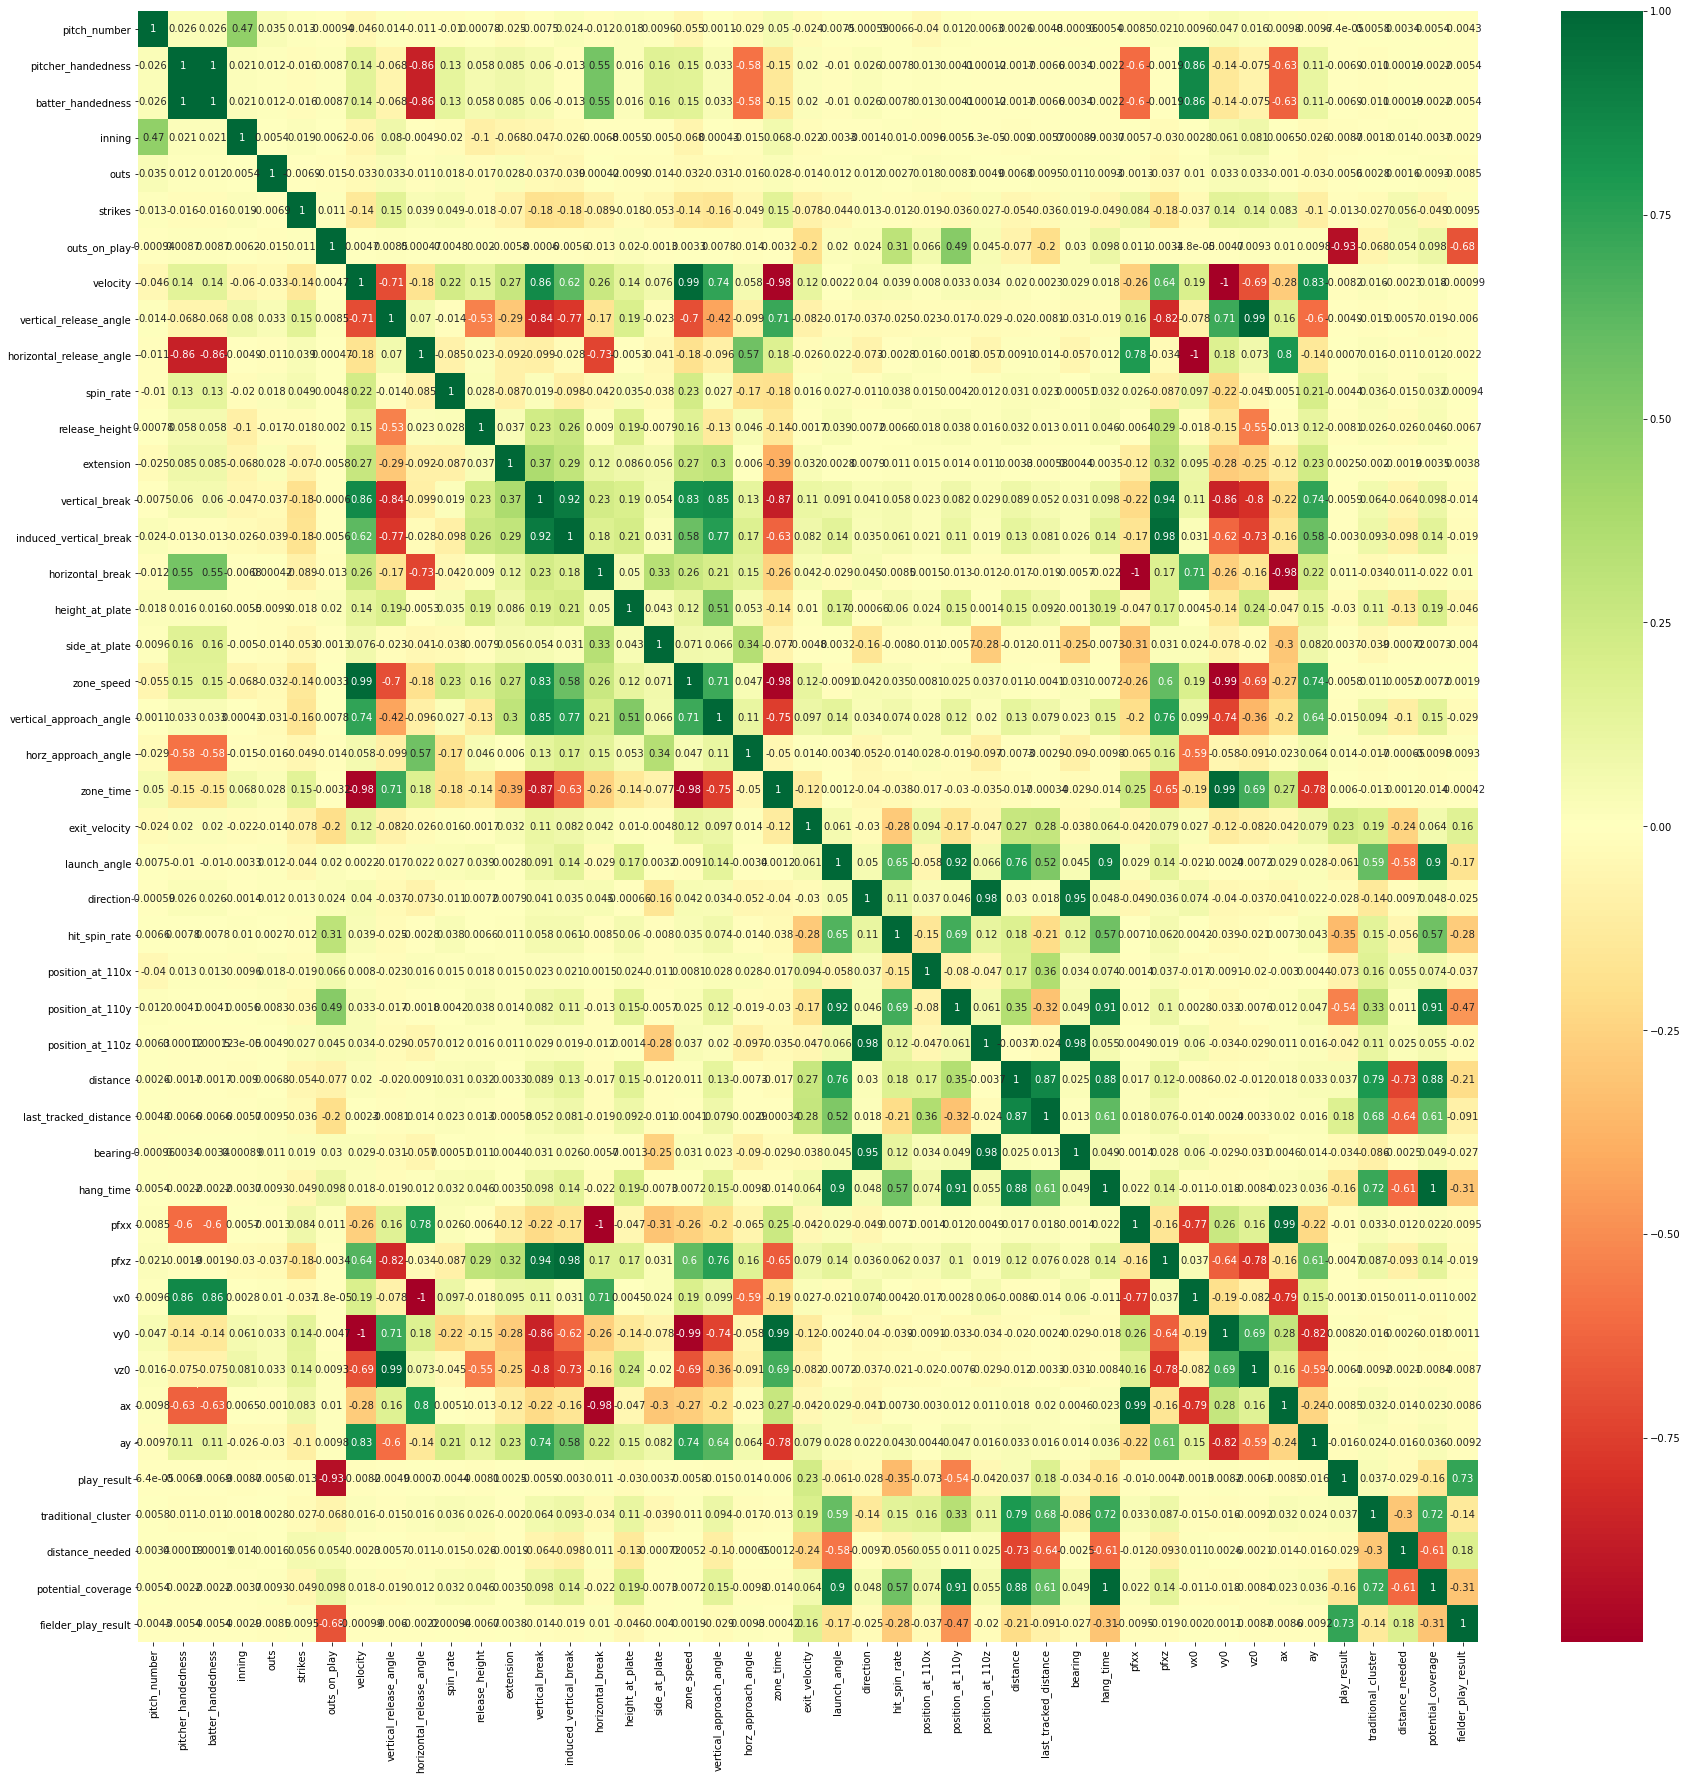

In [4]:
# Asks for Sprint Speeds of team's defensive to guage how many outs this specific defense can produce 
# Pre-processes entire dataset
training_data = prepare_data()

In [10]:
training_data.head(5)

,batter_name,pitch_number,pitcher_handedness,batter_handedness,inning,outs,strikes,outs_on_play,velocity,vertical_release_angle,...,vx0,vy0,vz0,ax,ay,play_result,traditional_cluster,distance_needed,potential_coverage,fielder_play_result
26,"Sortino, Tony",46.0,1,1,2.0,0.0,2.0,0.0,84.391666,-2.359937,...,-4.012645,-122.793201,-5.566694,11.164828,24.309769,1,8.0,-28.017677,122.326190,0.0
28,"Stephens, DJ",120.0,1,1,4.0,2.0,2.0,1.0,83.331974,-1.191039,...,-1.773379,-121.337696,-3.181724,6.496679,26.234568,0,4.0,143.080196,1.756146,0.0
31,"Thompson, Ollie",187.0,1,1,6.0,1.0,0.0,2.0,88.226066,-2.535825,...,6.051842,-128.234553,-6.164899,-9.596953,27.155100,0,4.0,133.551869,4.035883,0.0
32,"Delacruz, Angel",103.0,1,1,4.0,1.0,1.0,1.0,88.107635,-0.999202,...,3.466417,-128.270981,-2.796772,-10.269601,28.636330,0,4.0,45.908161,150.213739,0.0
33,"Martinez, Erick",217.0,1,1,7.0,2.0,0.0,1.0,86.009451,-0.884502,...,6.004371,-125.041783,-2.825460,-13.611623,26.920149,0,4.0,125.304158,7.702020,0.0


In [11]:
# Subsetted Data to introduce option to personalize the model to the defensive pitcher's handedness 
training_data_right = training_data[training_data['pitcher_handedness'] == 1]
training_data_left = training_data[training_data['pitcher_handedness'] == 0]

In [7]:
'''
Coded K Means clustering from scratch because it performed better than the scikit-learn k means clustering when trying 
to create clusters that maximized number of outs on balls in play.

'''

class K_Means:
    def __init__(self, k=7,tol=0.0,max_iter = 300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self,data):
        self.centroids = {}
        for i in range(self.k):
            self.centroids[i] = data[i] 
            
        for i in range(self.max_iter):
            self.classifications = {}
            
            for i in range(self.k):
                self.classifications[i] = []
                
            for featureset in data:
                distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
                
            prev_centroids = dict(self.centroids)
            
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis = 0)
            
            optimized = True
            
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid - original_centroid)/ original_centroid * 100.0) > self.tol:
                    optimized = False
                
            if optimized:
                break
                
    def predict(self,data):
        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [8]:
'''
Trains Logistic Regression Model on Traditional Fielder Cluster and tests them on Shifted Fielder Cluster to compare
the number of outs produced in both clusters, outputs positioning of cluster that maximizes outs. 
'''

def fetch_shift(training_data): 
    # Ask user for specific batter's data to train model with
    
    name = input("Batter's first and last name: ").split(" ")
    
    # Ask user for pitcher's handedness to provide better results
    handedness = input("Pitcher Handedness (optional) : ")
    
    # Searches dictionary of batters in O(1) to pull specific batter's data
    if len(name) == 2:
        first_name = name[0].capitalize()
        last_name = name[1].capitalize()
        print("Preprocessing Batted Ball Data for " + first_name + " " + last_name + "...")
        
        if handedness == 'Right':
            training_data = training_data[training_data['pitcher_handedness'] == 1]
        elif handedness == 'Left':
            training_data = training_data[training_data['pitcher_handedness'] == 0]

        batters = training_data.groupby("batter_name", as_index=False)
        batter_dict = dict(iter(batters))
        Batter = batter_dict[str(last_name + ', ' + first_name)]
        
        print(first_name + " " + last_name + " has " + str(len(Batter)) + " Batted Balls In Play.")
     
        
        
        
        # Subsets overall data into 7 subsets where each represents balls hit to fielders in traditional location 
        traditional_1B = training_data.loc[training_data['traditional_cluster'] == 3]
        traditional_2B = training_data.loc[training_data['traditional_cluster'] == 4]
        traditional_3B = training_data.loc[training_data['traditional_cluster'] == 5]
        traditional_SS = training_data.loc[training_data['traditional_cluster'] == 6]
        traditional_LF = training_data.loc[training_data['traditional_cluster'] == 7]
        traditional_CF = training_data.loc[training_data['traditional_cluster'] == 8]
        traditional_RF = training_data.loc[training_data['traditional_cluster'] == 9]
        
       
        # Subsets specific batter's data into 7 subsets where each represents balls hit to fielders in traditional location 
        traditional_cluster_0 = Batter.loc[Batter['traditional_cluster'] == 3]
        traditional_cluster_1 = Batter.loc[Batter['traditional_cluster'] == 4]
        traditional_cluster_2 = Batter.loc[Batter['traditional_cluster'] == 5]
        traditional_cluster_3 = Batter.loc[Batter['traditional_cluster'] == 6]
        traditional_cluster_4 = Batter.loc[Batter['traditional_cluster'] == 7]
        traditional_cluster_5 = Batter.loc[Batter['traditional_cluster'] == 8]
        traditional_cluster_6 = Batter.loc[Batter['traditional_cluster'] == 9]
        clusters = ['traditional_cluster_0','traditional_cluster_1','traditional_cluster_2','traditional_cluster_3','traditional_cluster_4','traditional_cluster_5','traditional_cluster_6']
        
        # Subsets batter data into 7 k-means clusters based on distance and direction which are the (x,y) coords of batted ball
        # Assigns the cluster given (0-6) to data point to a feature labeled 'custom_cluster'
        location = Batter[['distance','direction']]
        location_scaled = preprocessing.scale(location)
        clf = K_Means()
        clf.fit(location_scaled)
        Batter = Batter.reset_index(drop=True)
        for i, bip in Batter.iterrows():
            Batter.at[i,'custom_cluster'] = clf.predict(location_scaled[i])
           
        # For Data Visual
        Batter.to_csv('clusters.csv')
        
        # Subsets specific batter's k-means clustered data into 7 subsets where each represents balls hit to fielders in optimal location 
        cluster_0 = Batter.loc[Batter['custom_cluster'] == 0]
        cluster_1 = Batter.loc[Batter['custom_cluster'] == 1]
        cluster_2 = Batter.loc[Batter['custom_cluster'] == 2]
        cluster_3 = Batter.loc[Batter['custom_cluster'] == 3]
        cluster_4 = Batter.loc[Batter['custom_cluster'] == 4]
        cluster_5 = Batter.loc[Batter['custom_cluster'] == 5]
        cluster_6 = Batter.loc[Batter['custom_cluster'] == 6]
        custom_clusters = [0,1,2,3,4,5,6]
        
        # x coordinate of where each fielder's optimal location on the field is (how far away from origin)
        mean_distances = []
        mean_distances.append(cluster_0['distance'].mean())
        mean_distances.append(cluster_1['distance'].mean())
        mean_distances.append(cluster_2['distance'].mean())
        mean_distances.append(cluster_3['distance'].mean())
        mean_distances.append(cluster_4['distance'].mean())
        mean_distances.append(cluster_5['distance'].mean())
        mean_distances.append(cluster_6['distance'].mean())
       
        
        # y coordinate of where each fielder's optimal location on the field is (how many degrees to the left/right of origin)
        mean_directions = []
        mean_directions.append(cluster_0['direction'].mean())
        mean_directions.append(cluster_1['direction'].mean())
        mean_directions.append(cluster_2['direction'].mean())
        mean_directions.append(cluster_3['direction'].mean())
        mean_directions.append(cluster_4['direction'].mean())
        mean_directions.append(cluster_5['direction'].mean())
        mean_directions.append(cluster_6['direction'].mean())
        
        
        

        # pariing appropriate fielder with it's optimal (x,y) coordinates to field at 
        cluster_means = pd.DataFrame()
        cluster_means['custom_cluster'] = custom_clusters
        cluster_means['distance'] = mean_distances
        cluster_means['direction'] = mean_directions
        
        
        # (x,y) coordinates of traditional fielding locations from MLB.com
        traditional_positions = pd.read_csv('traditional_field.csv')
        traditional_positions = traditional_positions.drop(columns = ['Unnamed: 0'])
        
        # (x,y) coordinates of optimal fielding locations from k-means clustering algo
        shifted_positions = cluster_means 
        
        # Assign each batted ball to the fielder closest to it based on optimal fielding positions from k-means clustering algo
        shifted_positions = shifted_positions.sort_values(by=['direction'],ascending = True)
        shifted_positions_array = np.array(shifted_positions)
        shifted_positions_list = list(shifted_positions_array)
        shifted_positions_dict = {}
        for position in shifted_positions_list:
            shifted_positions_dict[position[0]] = position[1:3]
        
        
        
        cluster_to_position = {}
        player_options = [3,4,5,6,7,8,9]
        for cluster,coordinates in shifted_positions_dict.items():
            if(((coordinates[0]<= 180) and (coordinates[0] >= 0)) and ((coordinates[1] <= 45) and (coordinates[1] >= 25))) and 3 in player_options:
                cluster_to_position[cluster] = 3
                player_options.remove(3)
                continue
            elif(((coordinates[0]<= 180) and (coordinates[0] >= 0)) and ((coordinates[1] <= 20) and (coordinates[1] >= 0))) and 4 in player_options:
                cluster_to_position[cluster] = 4
                player_options.remove(4)
                continue
            elif (((coordinates[0]<= 180) and (coordinates[0] >= 0)) and (coordinates[1] <= -22.5) and (coordinates[1]>= -45) and 5 in player_options):
                cluster_to_position[cluster] = 5
                player_options.remove(5)
                continue
            elif (((coordinates[0]<= 180) and (coordinates[0] >= 0)) and (coordinates[1] <= 0) and (coordinates[1]>= -22.5) and 6 in player_options):
                cluster_to_position[cluster] = 6
                player_options.remove(6)
                continue
            elif (((coordinates[0]<= 309) and (coordinates[0] >= 210)) and (coordinates[1] <= -15) and (coordinates[1]>= -45) and 7 in player_options):
                cluster_to_position[cluster] = 7
                player_options.remove(7)
                continue
            elif (((coordinates[0]<= 347) and (coordinates[0]>= 225)) and (coordinates[1] <= 20) and (coordinates[1]>= -20) and 8 in player_options):
                cluster_to_position[cluster] = 8
                player_options.remove(8)
                continue
            elif (((coordinates[0]<= 309) and (coordinates[0] >= 210)) and (coordinates[1] <= 45) and (coordinates[1]>= 20) and 9 in player_options):
                cluster_to_position[cluster] = 9
                player_options.remove(9)
                continue
                
             
                
        for cluster,position in cluster_to_position.items():
            shifted_positions_dict.pop(cluster)
            
        
        traditional_positions_array = np.array(traditional_positions)

        for cluster,coodinates in shifted_positions_dict.items():
            dist = 99999
            for j,tradtional_cluster in enumerate(traditional_positions_array):
                new_distance = find_distance(coodinates[0:2],tradtional_cluster)
                if new_distance < dist and j+3 in player_options:
                    dist = new_distance
                    cluster_to_position[cluster] = j+3
            player_options.remove(int(cluster_to_position[cluster]))

            
        
            
            
        print()
        
        
        
     
        
        
        # Preparing Overall Traditional Fielding Dataset for Logistic Regression
        
        college_trad_1B_lr = traditional_1B[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        college_trad_2B_lr = traditional_2B[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        college_trad_3B_lr = traditional_3B[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        college_trad_SS_lr = traditional_SS[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        college_trad_LF_lr = traditional_LF[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        college_trad_CF_lr = traditional_CF[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        college_trad_RF_lr = traditional_RF[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        
        
        # Preparing Batter's Traditional Fielding Datasets for Logistic Regression
        clusters = pd.read_csv('clusters.csv')
        clusters = clusters.drop(columns = ['Unnamed: 0'])
        
        batter_traditional_1B = clusters.loc[clusters['traditional_cluster'] == 3]
        batter_traditional_2B = clusters.loc[clusters['traditional_cluster'] == 4]
        batter_traditional_3B = clusters.loc[clusters['traditional_cluster'] == 5]
        batter_traditional_SS = clusters.loc[clusters['traditional_cluster'] == 6]
        batter_traditional_LF = clusters.loc[clusters['traditional_cluster'] == 7]
        batter_traditional_CF = clusters.loc[clusters['traditional_cluster'] == 8]
        batter_traditional_RF = clusters.loc[clusters['traditional_cluster'] == 9]
        
        batter_traditional_1B_lr = batter_traditional_1B[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        batter_traditional_2B_lr = batter_traditional_2B[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        batter_traditional_3B_lr = batter_traditional_3B[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        batter_traditional_SS_lr = batter_traditional_SS[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        batter_traditional_LF_lr = batter_traditional_LF[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        batter_traditional_CF_lr = batter_traditional_CF[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        batter_traditional_RF_lr = batter_traditional_RF[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        
        # Preparing Batter's Optimal Fielding Datasets for Logistic Regression
        cluster_to_position = dict([(value, key) for key, value in cluster_to_position.items()]) 
        cluster_to_position
        
        shift_1B = clusters.loc[clusters['custom_cluster'] == cluster_to_position[3]]
        shift_2B = clusters.loc[clusters['custom_cluster'] == cluster_to_position[4]]
        shift_3B = clusters.loc[clusters['custom_cluster'] == cluster_to_position[5]]
        shift_SS = clusters.loc[clusters['custom_cluster'] == cluster_to_position[6]]
        shift_LF = clusters.loc[clusters['custom_cluster'] == cluster_to_position[7]]
        shift_CF = clusters.loc[clusters['custom_cluster'] == cluster_to_position[8]]
        shift_RF = clusters.loc[clusters['custom_cluster'] == cluster_to_position[9]]
        
        shift_1B_lr = shift_1B[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        shift_2B_lr = shift_2B[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        shift_3B_lr = shift_3B[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        shift_SS_lr = shift_SS[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        shift_LF_lr = shift_LF[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        shift_CF_lr = shift_CF[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        shift_RF_lr = shift_RF[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage','fielder_play_result']]
        
        
        # Performs Logistic Regression, Position by Position, on Traditional subset and Optimal subset to predict which subset will generate more outs
        # If optimal subset generates more outs: place fielder at center of that optimal cluster
        # Else place fielder at traditional spot
        
        trads = [batter_traditional_1B_lr,batter_traditional_2B_lr,batter_traditional_3B_lr,batter_traditional_SS_lr,batter_traditional_LF_lr,batter_traditional_CF_lr,batter_traditional_RF_lr]
        shifts = [shift_1B_lr,shift_2B_lr,shift_3B_lr,shift_SS_lr,shift_LF_lr,shift_CF_lr,shift_RF_lr]
        
        total_bip = []
        trad_outs = []
        distances = []
        directions = []
        shift_outs = []
        position = []
        model_confidence = []
        confidences = []
        

        print()
        print("First Baseman Positioning:")
        print()

        # 1B Traditional
        bip = len(batter_traditional_1B_lr)
        X = preprocessing.scale(college_trad_1B_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
        y = college_trad_1B_lr['fielder_play_result']
        clf_1B = LogisticRegression(random_state=42).fit(X, y)
        expected_out_prob_1B = 0
        trad_1B_outs = 0
        if (bip):
            batter_X = preprocessing.scale(batter_traditional_1B_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            traditional_1B = clf_1B.predict_proba(batter_X)
            out_probs = []
            for probs in traditional_1B:
                out_probs.append(probs[0])
            batter_traditional_1B_lr['traditional_out_prob'] = out_probs
            expected_outs = sum(batter_traditional_1B_lr['traditional_out_prob'])
            model_confidence.append(expected_outs)
            expected_out_prob_1B = expected_outs / bip
            
            trad_1B_outs = bip - sum(batter_traditional_1B_lr['fielder_play_result'])
            out_prob = trad_1B_outs/bip
           
            total_bip.append(bip)
            trad_outs.append(trad_1B_outs)

            print("Traditional Range BIP: " + str(bip))
            print('Traditional Outs: ' + str(trad_1B_outs)) 
            print("----------------------------------------------------------------------------")
        # 1B Shift
        bip = len(shift_1B_lr)
        if (bip):
            X = preprocessing.scale(shift_1B_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            shift_1B = clf_1B.predict_proba(X)
            out_probs = []
            for probs in shift_1B:
                out_probs.append(probs[0])
            shift_1B_lr['shift_out_prob'] = out_probs
            
            trad_no_shift_1B_outs = bip - sum(shift_1B_lr['fielder_play_result'])
            trad_1B_out_prob = trad_no_shift_1B_outs / bip

            shift_1B_outs = int(sum(shift_1B_lr['shift_out_prob']))
            
            shift_1B_bip_outs = shift_1B_lr.loc[shift_1B_lr['shift_out_prob'] > 0.5]
            shift_1B_out_velos = list(shift_1B_bip_outs['exit_velocity'])
            
            shifted_1B_out_prob = shift_1B_outs / bip

            print("Shifted Range BIP: " + str(bip))
            print("Current Outs: " + str(trad_no_shift_1B_outs)) 
            print("Shifted Outs: " + str(shift_1B_outs)) 
            print()
            
            # Only Shift if more outs are generated with fielder in the optimal zone than with no fielder in the optimal zone and more than fielder in the traditional zone 
            # Why did I use prob for one and outs for another 
            if (shifted_1B_out_prob > trad_1B_out_prob and shift_1B_outs > trad_1B_outs):
                
                print("Shift the First Baseman!")
                position.append('Shift')
                distance = int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[3]]['distance'])
                if distance <110 or distance > 150:
                    distances.append(110)
                else:
                    distances.append(distance)

                direction = int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[3]]['direction'])

                if direction >= 45 or direction <= 25:
                    directions.append(34)
                else:
                    directions.append(direction)
                shift_outs.append(shift_1B_outs)
                
                # if shifted, need to adjust other zones to exclude balls in play that are taken care of by this shifted fielder 

                for trad in trads:
                    trad_velos = list(trad['exit_velocity'])
                    for bip in trad_velos:
                        if bip in shift_1B_out_velos:
                            trad = trad[trad['exit_velocity'] != bip]
                            

                for shift in shifts:
                    shift_velos = list(shift['exit_velocity'])
                    for bip in shift_velos:
                        if bip in shift_1B_out_velos:
                            shift = shift[shift['exit_velocity'] != bip]
                            


                
            else:
                print("Don't shift the First Baseman")
                position.append('Traditional')
                distance = traditional_positions.iloc[3-3]['distance']
                direction = traditional_positions.iloc[3-3]['direction']

                if distance <110:
                    distances.append(110)
                else:
                    distances.append(distance)

                if direction >= 45 or direction <= 25:
                    directions.append(34)
                else:
                    directions.append(direction)
                shift_outs.append(trad_1B_outs)

            
            total_bip.append(bip)
            

            
        else:    
            distances.append(110)
            directions.append(34)
        
        if (len(batter_traditional_1B_lr) and trad_1B_outs >0):
            confidence = int((1 - (abs(expected_outs-trad_1B_outs)/trad_1B_outs)) * 100)
            if confidence >= 0:
                print("Model Confidence for First Baseman: " + str(confidence) + '%')
            else:
                confidence = 0
                print("Model Confidence for First Baseman: 0 % ")
        else:
            confidence = 0
            print("Model Confidence for First Baseman: 0 % ")
            
        confidences.append(str(confidence) + '%')
            
        print("----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------")
        print()
        print("Second Baseman Positioning:")
        print()
        
        # 2B Traditional
        bip = len(batter_traditional_2B_lr)
        X = preprocessing.scale(college_trad_2B_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
        y = college_trad_2B_lr['fielder_play_result']
        clf_2B = LogisticRegression(random_state=42).fit(X, y)
        expected_out_prob_2B = 0
        trad_2B_outs = 0
        if (bip):
            batter_X = preprocessing.scale(batter_traditional_2B_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            traditional_2B = clf_2B.predict_proba(batter_X)
            out_probs = []
            for probs in traditional_2B:
                out_probs.append(probs[0])
            batter_traditional_2B_lr['traditional_out_prob'] = out_probs
            expected_outs = sum(batter_traditional_2B_lr['traditional_out_prob'])
            model_confidence.append(expected_outs)
            trad_2B_outs = bip - sum(batter_traditional_2B_lr['fielder_play_result'])
            out_prob = trad_2B_outs/bip
            expected_out_prob_2B = expected_outs / bip

            total_bip.append(bip)
            trad_outs.append(trad_2B_outs)

            print("Traditional Range BIP: " + str(bip))
            print('Traditional Outs: ' + str(trad_2B_outs))
            
        print("----------------------------------------------------------------------------")

        # 2B Shift
        bip = len(shift_2B_lr)
        if(bip):
            X = preprocessing.scale(shift_2B_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            shift_2B = clf_2B.predict_proba(X)
            out_probs = []
            for probs in shift_2B:
                out_probs.append(probs[0])
            shift_2B_lr['shift_out_prob'] = out_probs
            shift_2B_outs = int(sum(shift_2B_lr['shift_out_prob']))
            trad_no_shift_2B_outs = bip - sum(shift_2B_lr['fielder_play_result'])
            trad_2B_out_prob = trad_no_shift_2B_outs / bip
            
            shift_2B_bip_outs = shift_2B_lr.loc[shift_2B_lr['shift_out_prob'] > 0.5]
            shift_2B_out_velos = list(shift_2B_bip_outs['exit_velocity'])
            
            shifted_2B_out_prob = shift_2B_outs / bip
            print("Shifted Range BIP: " + str(bip))
            print("Current Outs: " + str(trad_no_shift_2B_outs)) 
            print( "Shifted Outs: " + str(shift_2B_outs)) 
            print()
            if (shifted_2B_out_prob > trad_2B_out_prob and shift_2B_outs > trad_2B_outs):
                print("Shift the Second Baseman")
                position.append('Shift')
                distance = int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[4]]['distance'])
                if distance <150:
                    distances.append(150)
                else:
                    distances.append(distance)
                directions.append(int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[4]]['direction']))
                

                for trad in trads:
                    trad_velos = list(trad['exit_velocity'])
                    for bip in trad_velos:
                        if bip in shift_2B_out_velos:
                            trad = trad[trad['exit_velocity'] != bip]
                            
                
                for shift in shifts:
                    shift_velos = list(shift['exit_velocity'])
                    for bip in shift_velos:
                        if bip in shift_2B_out_velos:
                            shift = shift[shift['exit_velocity'] != bip]
                            

                
                
                shift_outs.append(shift_2B_outs)
                
                
            else:
                print("Don't shift the Second Baseman!")
                position.append('Traditional')
                distance = traditional_positions.iloc[4-3]['distance']
                direction = traditional_positions.iloc[4-3]['direction']
                if distance <150:
                    distances.append(150)
                else:
                    distances.append(distance)

                directions.append(direction)
                shift_outs.append(trad_2B_outs)
            

            total_bip.append(bip)
            
        else:
            distances.append(150)
            directions.append(13)
        
        if (len(batter_traditional_2B_lr) and trad_2B_outs > 0 ):
            confidence = int((1 - (abs(expected_outs-trad_2B_outs)/trad_2B_outs)) * 100)
            if confidence >= 0:
                print("Model Confidence for Second Baseman: " + str(confidence) + '%')
            else:
                confidence = 0
                print("Model Confidence for Second Baseman: 0 % ")
        else:
            confidence = 0
            print("Model Confidence for Second Baseman: 0 % ")
        confidences.append(str(confidence) + '%')
        print("----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------")
        print()
        print("Third Baseman Positioning:")
        print()
        
        # 3B Traditional 
        bip = len(batter_traditional_3B_lr)
        X = preprocessing.scale(college_trad_3B_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
        y = college_trad_3B_lr['fielder_play_result']
        clf_3B = LogisticRegression(random_state=42).fit(X, y)
        expected_out_prob_3B = 0
        trad_3B_outs = 0
        if (bip):
            batter_X = preprocessing.scale(batter_traditional_3B_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            traditional_3B = clf_3B.predict_proba(batter_X)
            out_probs = []
            for probs in traditional_3B:
                out_probs.append(probs[0])
            batter_traditional_3B_lr['traditional_out_prob'] = out_probs
            expected_outs = sum(batter_traditional_3B_lr['traditional_out_prob'])
            model_confidence.append(expected_outs)
            trad_3B_outs = bip - sum(batter_traditional_3B_lr['fielder_play_result'])
            out_prob = trad_3B_outs/bip
            expected_out_prob_3B = expected_outs / bip

            total_bip.append(bip)
            trad_outs.append(trad_3B_outs)

            print("Traditional Range BIP: " + str(bip))
            print('Traditional Outs: ' + str(trad_3B_outs)) 
        print("----------------------------------------------------------------------------")


        # 3B Shift
        bip = len(shift_3B_lr)
        if(bip):
            X = preprocessing.scale(shift_3B_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            shift_3B = clf_3B.predict_proba(X)
            out_probs = []
            for probs in shift_3B:
                out_probs.append(probs[0])
            shift_3B_lr['shift_out_prob'] = out_probs
            shift_3B_outs = int(sum(shift_3B_lr['shift_out_prob']))
            trad_no_shift_3B_outs = bip - sum(shift_3B_lr['fielder_play_result'])
            trad_3B_out_prob = trad_no_shift_3B_outs / bip
            shifted_3B_out_prob = shift_3B_outs / bip
            
            shift_3B_bip_outs = shift_3B_lr.loc[shift_3B_lr['shift_out_prob'] > 0.5]
            shift_3B_out_velos = list(shift_3B_bip_outs['exit_velocity'])

            
            print("Shifted Range BIP: " + str(bip))
            print("Current Outs: " + str(trad_no_shift_3B_outs)) 
            print( "Shifted Outs: " + str(shift_3B_outs)) 
            print()
            
            if (shifted_3B_out_prob > trad_3B_out_prob and shift_3B_outs > trad_3B_outs):
                print("Shift the Third Baseman!")
                position.append('Shift')
                distance = int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[5]]['distance'])
                if distance <116:
                    distances.append(116)
                else:
                    distances.append(distance)
                directions.append(int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[5]]['direction']))
                shift_outs.append(shift_3B_outs)
                

                for trad in trads:
                    trad_velos = list(trad['exit_velocity'])
                    for bip in trad_velos:
                        if bip in shift_3B_out_velos:
                            trad = trad[trad['exit_velocity'] != bip]

                for shift in shifts:
                    shift_velos = list(shift['exit_velocity'])
                    for bip in shift_velos:
                        if bip in shift_3B_out_velos:
                            shift = shift[shift['exit_velocity'] != bip]
                            

                
                
            else:
                print("Don't shift the Third Baseman!")
                position.append('Traditional')
                distance = traditional_positions.iloc[5-3]['distance']
                if distance <116:
                    distances.append(116)
                else:
                    distances.append(distance)
                directions.append(traditional_positions.iloc[5-3]['direction'])
                shift_outs.append(trad_3B_outs)
                

            total_bip.append(bip)
            
        else:
            distances.append(116)
            directions.append(-30)
        
        if (len(batter_traditional_3B_lr) and trad_3B_outs > 0):
            confidence = int((1 - (abs(expected_outs-trad_3B_outs)/trad_3B_outs)) * 100)
            if confidence >= 0:
                print("Model Confidence for Third Baseman: " + str(confidence) + '%')
            else:
                confidence = 0
                print("Model Confidence for Third Baseman: 0 % ")
        else:
            confidence = 0
            print("Model Confidence for Third Baseman: 0 % ")
        confidences.append(str(confidence) + '%')
        print("----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------")
        print()
        print("Shortstop Positioning:")
        print()
        
        # SS Traditional
        bip = len(batter_traditional_SS_lr)
        X = preprocessing.scale(college_trad_SS_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
        y = college_trad_SS_lr['fielder_play_result']
        clf_SS = LogisticRegression(random_state=42).fit(X, y)
        expected_out_prob_SS = 0
        trad_SS_outs = 0
        if (bip):
            batter_X = preprocessing.scale(batter_traditional_SS_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            traditional_SS = clf_SS.predict_proba(batter_X)
            out_probs = []
            for probs in traditional_SS:
                out_probs.append(probs[0])
            batter_traditional_SS_lr['traditional_out_prob'] = out_probs
            expected_outs = sum(batter_traditional_SS_lr['traditional_out_prob'])
            model_confidence.append(expected_outs)
            trad_SS_outs = bip - sum(batter_traditional_SS_lr['fielder_play_result'])
            out_prob = trad_SS_outs/bip
            expected_out_prob_SS = expected_outs / bip

            total_bip.append(bip)
            trad_outs.append(trad_SS_outs)

            print("Traditional Range BIP: " + str(bip))
            print('Traditional Outs: ' + str(trad_SS_outs))     
        print("----------------------------------------------------------------------------")

        # SS Shift
        bip = len(shift_SS_lr)
        if(bip):
            X = preprocessing.scale(shift_SS_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            shift_SS = clf_SS.predict_proba(X)
            out_probs = []
            for probs in shift_SS:
                out_probs.append(probs[0])
            shift_SS_lr['shift_out_prob'] = out_probs
            shift_SS_outs = int(sum(shift_SS_lr['shift_out_prob']))
            trad_no_shift_SS_outs = bip - sum(shift_SS_lr['fielder_play_result'])
            trad_SS_out_prob = trad_no_shift_SS_outs / bip
            
            shift_SS_bip_outs = shift_SS_lr.loc[shift_SS_lr['shift_out_prob'] > 0.5]
            shift_SS_out_velos = list(shift_SS_bip_outs['exit_velocity'])
            
            shifted_SS_out_prob = shift_SS_outs / bip
            print("Shifted Range BIP: " + str(bip))
            print("Current Outs: " + str(trad_no_shift_SS_outs)) 
            print( "Shifted Outs: " + str(shift_SS_outs)) 
            print()

            if (shifted_SS_out_prob > trad_SS_out_prob and shift_SS_outs > trad_SS_outs):
                print("Shift the Shortstop!")
                position.append('Shift')
                distance = int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[6]]['distance'])
                if distance <146:
                    distances.append(146)
                else:
                    distances.append(distance)
                directions.append(int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[6]]['direction']))
                

                for trad in trads:
                    trad_velos = list(trad['exit_velocity'])
                    for bip in trad_velos:
                        if bip in shift_SS_out_velos:
                            trad = trad[trad['exit_velocity'] != bip]

                for shift in shifts:
                    shift_velos = list(shift['exit_velocity'])
                    for bip in shift_velos:
                        if bip in shift_SS_out_velos:
                            shift = shift[shift['exit_velocity'] != bip]
                            

               
                 
                shift_outs.append(shift_SS_outs)
                
            else:
                print("Don't shift the Shortstop!")
                position.append('Traditional')
                distance = traditional_positions.iloc[6-3]['distance']
                direction = traditional_positions.iloc[6-3]['direction']

                if distance <146:
                    distances.append(146)
                else:
                    distances.append(distance)
                directions.append(direction)
                shift_outs.append(trad_SS_outs)
                
            total_bip.append(bip)
            
        else:
            distances.append(146)
            directions.append(-12)

        if (len(batter_traditional_SS_lr) and trad_SS_outs > 0):   
            confidence = int((1 - (abs(expected_outs-trad_SS_outs)/trad_SS_outs)) * 100)
            if confidence >= 0:
                print("Model Confidence for Shortstop: " + str(confidence) + '%')
            else:
                confidence = 0
                print("Model Confidence for Shortstop: 0 % ")
        else:
            confidence = 0
            print("Model Confidence for Shortstop: 0 % ")
        confidences.append(str(confidence) + '%')
        print("----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------")
        print()
        print("Left Fielder Positioning:")
        print()
        
        # LF Traditional 
        bip = len(batter_traditional_LF_lr)
        X = preprocessing.scale(college_trad_LF_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
        y = college_trad_LF_lr['fielder_play_result']
        clf_LF = LogisticRegression(random_state=42).fit(X, y)
        expected_out_prob_LF = 0
        trad_LF_outs = 0
        if (bip):
            batter_X = preprocessing.scale(batter_traditional_LF_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            traditional_LF = clf_LF.predict_proba(batter_X)
            out_probs = []
            for probs in traditional_LF:
                out_probs.append(probs[0])
            batter_traditional_LF_lr['traditional_out_prob'] = out_probs
            expected_outs = sum(batter_traditional_LF_lr['traditional_out_prob'])
            model_confidence.append(expected_outs)
            trad_LF_outs = bip - sum(batter_traditional_LF_lr['fielder_play_result'])
            out_prob = trad_LF_outs/bip
            expected_out_prob_LF = expected_outs / bip

            total_bip.append(bip)
            trad_outs.append(trad_LF_outs)

            print("Traditional Range BIP: " + str(bip))
            print('Traditional Outs: ' + str(trad_LF_outs))     
            
        print("----------------------------------------------------------------------------")
        

        # LF Shift
        bip = len(shift_LF_lr)
        if(bip):
            X = preprocessing.scale(shift_LF_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            shift_LF = clf_LF.predict_proba(X)
            out_probs = []
            for probs in shift_LF:
                out_probs.append(probs[0])
            shift_LF_lr['shift_out_prob'] = out_probs
            shift_LF_outs = int(sum(shift_LF_lr['shift_out_prob']))
            trad_no_shift_LF_outs = bip - sum(shift_LF_lr['fielder_play_result'])
            trad_LF_out_prob = trad_no_shift_LF_outs / bip
            
            shift_LF_bip_outs = shift_LF_lr.loc[shift_LF_lr['shift_out_prob'] > 0.5]
            shift_LF_out_velos = list(shift_LF_bip_outs['exit_velocity'])
            
            shifted_LF_out_prob = shift_LF_outs / bip
            print("Shifted Range BIP: " + str(bip))
            
            print("Current Outs: " + str(trad_no_shift_LF_outs)) 
            print( "Shifted Outs: " + str(shift_LF_outs)) 
            print()
            if (shifted_LF_out_prob > trad_LF_out_prob and shift_LF_outs > trad_LF_outs):
                print("Shift the Left Fielder!")
                position.append('Shift')
                distance = int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[7]]['distance'])
                if distance <225:
                    distances.append(297)
                else:
                    distances.append(distance)
                directions.append(int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[7]]['direction']))
                

                for trad in trads:
                    trad_velos = list(trad['exit_velocity'])
                    for bip in trad_velos:
                        if bip in shift_LF_out_velos:
                            trad = trad[trad['exit_velocity'] != bip]
                            

                for shift in shifts:
                    shift_velos = list(shift['exit_velocity'])
                    for bip in shift_velos:
                        if bip in shift_LF_out_velos:
                            shift = shift[shift['exit_velocity'] != bip]
                            

                
                
                shift_outs.append(shift_LF_outs)
                
            else:
                print("Don't shift the Left Fielder!")
                position.append('Traditional')
                distances.append(traditional_positions.iloc[7-3]['distance'])
                directions.append(traditional_positions.iloc[7-3]['direction'])
                shift_outs.append(trad_LF_outs)
                

            total_bip.append(bip)
            
        else:
            distances.append(297)
            directions.append(-27)
        
        if (len(batter_traditional_LF_lr) and trad_LF_outs > 0):
            confidence = int((1 - (abs(expected_outs-trad_LF_outs)/trad_LF_outs)) * 100)
            if confidence >= 0:
                print("Model Confidence for Left Fielder: " + str(confidence) + '%')
            else:
                confidence = 0
                print("Model Confidence for Left Fielder: 0 % ")
        else:
            confidence = 0
            print("Model Confidence for Left Fielder: 0 % ")
        confidences.append(str(confidence) + '%')
        print("----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------")        
        print()
        print("Center Fielder Positioning:")
        print()
        # CF Traditional
        bip = len(batter_traditional_CF_lr)
        X = preprocessing.scale(college_trad_CF_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
        y = college_trad_CF_lr['fielder_play_result']
        clf_CF = LogisticRegression(random_state=42).fit(X, y)
        expected_out_prob_CF = 0
        trad_CF_outs = 0
        if (bip):
            batter_X = preprocessing.scale(batter_traditional_CF_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            traditional_CF = clf_CF.predict_proba(batter_X)
            out_probs = []
            for probs in traditional_CF:
                out_probs.append(probs[0])
            batter_traditional_CF_lr['traditional_out_prob'] = out_probs
            expected_outs = sum(batter_traditional_CF_lr['traditional_out_prob'])
            model_confidence.append(expected_outs)
            trad_CF_outs = bip - sum(batter_traditional_CF_lr['fielder_play_result'])
            out_prob = trad_CF_outs/bip
            expected_out_prob_CF = expected_outs / bip

            total_bip.append(bip)
            trad_outs.append(trad_CF_outs)

            print("Traditional Range BIP: " + str(bip))
            print('Traditional Outs: ' + str(trad_CF_outs)) 
            
        print("----------------------------------------------------------------------------")
             
        # CF Shift
        bip = len(shift_CF_lr)
        if(bip):
            X = preprocessing.scale(shift_CF_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            shift_CF = clf_CF.predict_proba(X)
            out_probs = []
            for probs in shift_CF:
                out_probs.append(probs[0])
            shift_CF_lr['shift_out_prob'] = out_probs
            shift_CF_outs = int(sum(shift_CF_lr['shift_out_prob']))
            trad_no_shift_CF_outs = bip - sum(shift_CF_lr['fielder_play_result'])
            trad_CF_out_prob = trad_no_shift_CF_outs / bip
            
            shift_CF_bip_outs = shift_CF_lr.loc[shift_CF_lr['shift_out_prob'] > 0.5]
            shift_CF_out_velos = list(shift_CF_bip_outs['exit_velocity'])
            
            shifted_CF_out_prob = shift_CF_outs / bip
            print("Shifted Range BIP: " + str(bip))
            
            print("Current Outs: " + str(trad_no_shift_CF_outs)) 
            print( "Shifted Outs: " + str(shift_CF_outs))
            print()
            if ((shifted_CF_out_prob > trad_CF_out_prob) and (shift_CF_outs > trad_CF_outs)):
                print("Shift the Center Fielder!")
                position.append('Shift')
                distance = int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[8]]['distance'])
                if distance <225:
                    distances.append(321)
                else:
                    distances.append(distance)

                directions.append(int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[8]]['direction']))
                shift_outs.append(shift_CF_outs)
                

                for trad in trads:
                    trad_velos = list(trad['exit_velocity'])
                    for bip in trad_velos:
                        if bip in shift_CF_out_velos:
                            trad = trad[trad['exit_velocity'] != bip]

                for shift in shifts:
                    shift_velos = list(shift['exit_velocity'])
                    for bip in shift_velos:
                        if bip in shift_CF_out_velos:
                            shift = shift[shift['exit_velocity'] != bip]

            else:
                print("Don't shift the Center Fielder!")
                position.append('Traditional')
                distances.append(traditional_positions.iloc[8-3]['distance'])
                directions.append(traditional_positions.iloc[8-3]['direction'])
                shift_outs.append(trad_CF_outs)
                

            total_bip.append(bip)
        else:
            distances.append(321)
            directions.append(-1)
        
        if len(batter_traditional_CF_lr) and trad_CF_outs >0:
            confidence = int((1 - (abs(expected_outs-trad_CF_outs)/trad_CF_outs)) * 100)
            if confidence >= 0:
                print("Model Confidence for Center Fielder: " + str(confidence) + '%')
            else:
                confidence = 0
                print("Model Confidence for Center Fielder: 0 % ") 
        else:
            confidence = 0
            print("Model Confidence for Center Fielder: 0 % ")
        confidences.append(str(confidence) + '%')
        print("----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------")        
        print()
        print("Right Fielder Positioning:")
        print()
        # RF Traditional
        bip = len(batter_traditional_RF_lr)
        X = preprocessing.scale(college_trad_RF_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
        y = college_trad_RF_lr['fielder_play_result']
        clf_RF = LogisticRegression(random_state=42).fit(X, y)
        expected_out_prob_RF = 0
        trad_RF_outs = 0
        if (bip):
            batter_X = preprocessing.scale(batter_traditional_RF_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            traditional_RF = clf_RF.predict_proba(batter_X)
            out_probs = []
            for probs in traditional_RF:
                out_probs.append(probs[0])
            batter_traditional_RF_lr['traditional_out_prob'] = out_probs
            expected_outs = sum(batter_traditional_RF_lr['traditional_out_prob'])
            model_confidence.append(expected_outs)
            trad_RF_outs = bip - sum(batter_traditional_RF_lr['fielder_play_result'])
            out_prob = trad_RF_outs/bip
            expected_out_prob_RF = expected_outs / bip
            trad_outs.append(trad_RF_outs)
            print("Traditional Range BIP: " + str(bip))
            print('Traditional Outs: ' + str(trad_RF_outs)) 
            
            total_bip.append(bip)
        
        
        print("----------------------------------------------------------------------------")


            
        # RF Shift
        bip = len(shift_RF_lr)
        if (bip):
            X = preprocessing.scale(shift_RF_lr[['exit_velocity','launch_angle','distance','hang_time','distance_needed','potential_coverage']])
            shift_RF = clf_RF.predict_proba(X)
            out_probs = []
            for probs in shift_RF:
                out_probs.append(probs[0])
            shift_RF_lr['shift_out_prob'] = out_probs
            shift_RF_outs = int(sum(shift_RF_lr['shift_out_prob']))
            trad_no_shift_RF_outs = bip - sum(shift_RF_lr['fielder_play_result'])
            trad_RF_out_prob = trad_no_shift_RF_outs / bip
            
            shift_RF_bip_outs = shift_RF_lr.loc[shift_RF_lr['shift_out_prob'] > 0.5]
            shift_RF_out_velos = list(shift_RF_bip_outs['exit_velocity'])
            
            
            shifted_RF_out_prob = shift_RF_outs / bip
            print("Shifted Range BIP: " + str(bip))
            
            print("Current Outs: " + str(trad_no_shift_RF_outs)) 
            print( "Shifted Outs: " + str(shift_RF_outs)) 
            print()
            if (shifted_RF_out_prob > trad_RF_out_prob and shift_RF_outs > trad_RF_outs):
                print("Shift the Right Fielder!")
                position.append('Shift')
                distance = int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[7]]['distance'])
                if distance <225:
                    distances.append(295)
                else:
                    distances.append(distance)
                directions.append(int(shifted_positions[shifted_positions['custom_cluster']== cluster_to_position[9]]['direction']))
                shift_outs.append(shift_RF_outs)
                

                for trad in trads:
                    trad_velos = list(trad['exit_velocity'])
                    for bip in trad_velos:
                        if bip in shift_RF_out_velos:
                            trad = trad[trad['exit_velocity'] != bip]
                            

                for shift in shifts:
                    shift_velos = list(shift['exit_velocity'])
                    for bip in shift_velos:
                        if bip in shift_RF_out_velos:
                            shift = shift[shift['exit_velocity'] != bip]
                            
   

                
            else:
                print("Don't shift the Right Fielder!")
                position.append('Traditional')
                distances.append(traditional_positions.iloc[9-3]['distance'])
                directions.append(traditional_positions.iloc[9-3]['direction'])
                shift_outs.append(trad_RF_outs)

            total_bip.append(bip)
            
        else:
            distances.append(295)
            directions.append(27)

        if (len(batter_traditional_RF_lr) and trad_RF_outs > 0):
            confidence = int((1 - (abs(expected_outs-trad_RF_outs)/trad_RF_outs)) * 100)
            if confidence >= 0:
                print("Model Confidence for Right Fielder: " + str(confidence) + '%')
            else:
                confidence = 0
                print("Model Confidence for Right Fielder: 0 % ")
        else:
            confidence = 0
            print("Model Confidence for Right Fielder: 0 % ")
        confidences.append(str(confidence) + '%')
        print("----------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------")        
        print("----------------------------------------------------------------------------")
        
        bip = len(Batter)
        print("Total BIP: " + str(len(Batter)))
        print()
        
        total_trad_outs = sum(trad_outs)
        trad_out_prob = int((total_trad_outs/bip)*100)
        print("Traditional Outs: " + str(total_trad_outs))
        print("Traditional Out Probability: " + str(trad_out_prob) + "%")
        
        print()
        
        
        total_shift_outs = sum(shift_outs)
        shift_out_prob = int((total_shift_outs/bip)*100)
        print("Shifted Outs: " + str(total_shift_outs))
        print("Shifted Out Probability: " + str(shift_out_prob) + "%")
        print()
        
        print("Outs above Tradional Shift: " + str(total_shift_outs - total_trad_outs))
        
        confidence = 1 - abs(1 - sum(model_confidence)/total_trad_outs)
        
        print("Model Confidence: " + str(int(confidence * 100)) + '%')
        print()
        
        print("Creating most efficient shift...")
        positioning = pd.DataFrame()
        positioning['fielder'] = ['1B','2B','3B','SS','LF','CF','RF']
        positioning['position'] = position
        positioning['distance'] = distances
        positioning['direction'] = directions
        positioning['confidence'] = confidences
        
        # For Data Visual
        positioning.to_csv('Final_Shift.csv')
        print(positioning)
    
    else:
        print("ERROR: Please enter batter's first and last name.")
        print("For example: Spencer Torkelson")
        
        fetch_shift()
        

In [9]:
fetch_shift(training_data)

Batter's first and last name: bobby seymour
Pitcher Handedness (optional) : 
Preprocessing Batted Ball Data for Bobby Seymour...
Bobby Seymour has 298 Batted Balls In Play.


First Baseman Positioning:

Traditional Range BIP: 48
Traditional Outs: 35.0
----------------------------------------------------------------------------
Shifted Range BIP: 67
Current Outs: 56.0
Shifted Outs: 49

Don't shift the First Baseman
Model Confidence for First Baseman: 90%
----------------------------------------------------------------------------
----------------------------------------------------------------------------

Second Baseman Positioning:

Traditional Range BIP: 84
Traditional Outs: 60.0
----------------------------------------------------------------------------
Shifted Range BIP: 66
Current Outs: 47.0
Shifted Outs: 47

Don't shift the Second Baseman!
Model Confidence for Second Baseman: 95%
----------------------------------------------------------------------------
-----------------------